In [101]:
import numpy as np
import sys, os, git, lammps_logfile
import warnings
warnings.filterwarnings("ignore")

In [102]:
def read_output_wham(filename = "umbrella-sampling.dat"):
    coor_data = []
    with open(filename, 'r') as file:
        section = None
        for line in file:
            if "#Coor" in line:
                section = "coor"
            elif "#Window" in line:
                section = "window"
            if (section == "coor") & ("#" not in line):
                parts = line.split("\t")
                coor_data.append([np.float32(parts[0]), np.float32(parts[1])])
    return np.array(coor_data)

In [103]:
def create_metadata(k, filename = "umbrella-sampling.meta"):
    f = open(filename, "w")
    for a in np.arange(1,16):
        f.write("umbrella-sampling."+str(a)+".dat " + str(4*a-32)+" "+str(k)+"\n")
    f.close()

In [105]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
path_in_folder = current_path[len(git_path)+1:]
sys.path.append(git_path + "/files/shared-pyplot")
from plttools import PltTools
path_figures = git_path + "/figures/"

In [106]:
color1 = np.array([1, 0.682, 0.286])
color2 = np.array([0.008, 0.294, 0.478])
color3 = np.array([0.267, 0.647, 0.761])
color4 = np.array([0.5, 0.5, 0.5])

## Control overlap

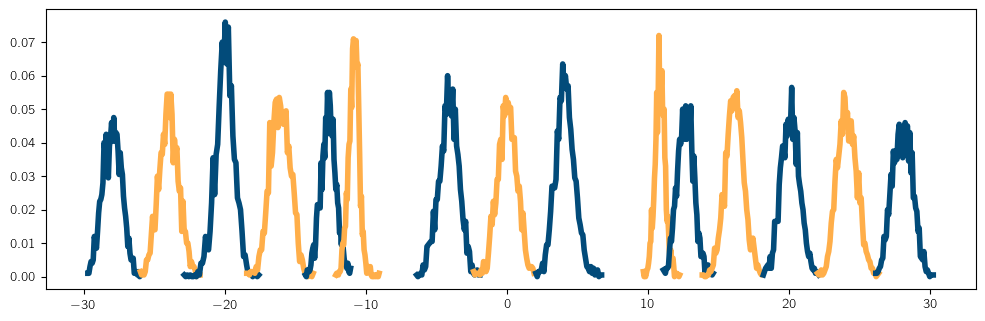

In [107]:
# Initialise figure
myplt = PltTools()
myplt.prepare_figure(fig_size = (12,8), dark_mode = False,
                     transparency = False, use_serif=False, n_colone=1, n_line=2)
# Panel a
myplt.add_panel()
for n in np.arange(1,26):
    file = "umbrella-sampling."+str(n)+".dat"
    if os.path.exists(file):
        data = np.loadtxt(file)
        x0 = data[:,2][0]
        x = data[:,1]
        a, b = np.histogram(x, bins=50)
        centers = (b[1:]+b[:-1])/2
        a = a / np.sum(a)
        if (n % 2 == 0):
            myplt.add_plot(x = centers, y = a, type = "plot", linewidth_data = 3,
                    marker = "-", data_color = color1, markersize = 12)
        else:
            myplt.add_plot(x = centers, y = a, type = "plot", linewidth_data = 3,
                    marker = "-", data_color = color2, markersize = 12)

# Run WHAM

In [108]:
create_metadata(k = 0.5)
os.system("./wham -30 30 50 1e-8 119.8 0 umbrella-sampling.meta umbrella-sampling.dat > /dev/null 2>&1")

0

## Compare output with imposed potential

In [109]:
sigma = 3.405 # Angstrom
epsilon = 0.238 # Kcal/mol
U0 = 10*epsilon # Kcal/mol

delta = 1.0 # Angstrom
x0 = 10.0 # Angstrom

x = np.linspace(-50, 50, 10000)  # Angstrom
U = U0*np.arctan((x+x0)/delta)-U0*np.arctan((x-x0)/delta)
F = U0/(((x-x0)**2)/delta**2+1)/delta-U0/(((x+x0)**2)/delta**2+1)/delta

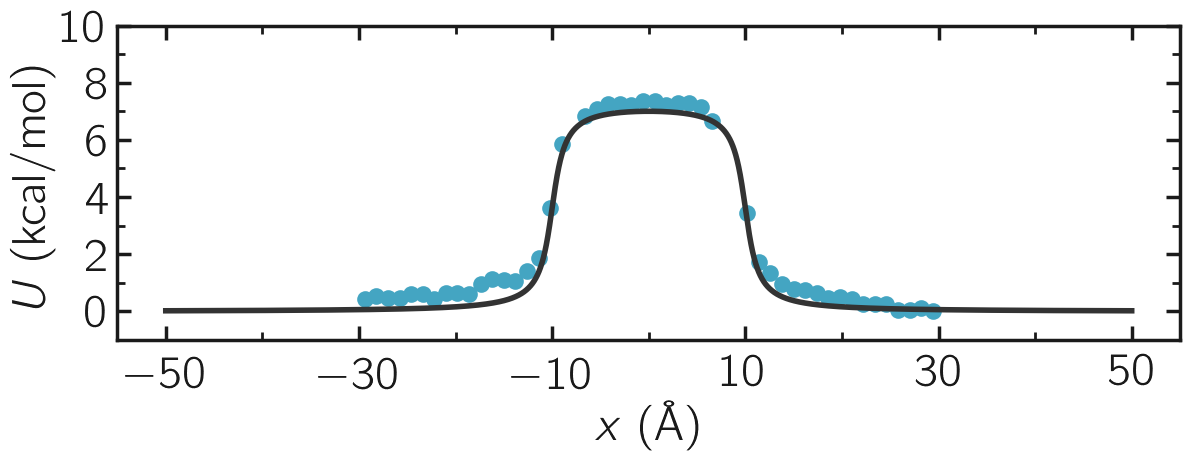

In [110]:
filename = "US-free-energy"

# Initialise figure
myplt = PltTools()
myplt.prepare_figure(fig_size = (12,8), dark_mode = False,
                     transparency = False, use_serif=False, n_colone=1, n_line=2)
# Panel a
myplt.add_panel()
output_wham = read_output_wham()
myplt.add_plot(x = output_wham[:,0], y = output_wham[:,1], type = "plot", linewidth_data = 3,
            marker = "o", data_color = color3, markersize = 12)
myplt.add_plot(x = x, y = U, type = "plot", linewidth_data = 3,
    marker = "-", data_color = np.array([0.2, 0.2, 0.2]), markersize = 12)

myplt.complete_panel(xlabel = r'$x ~ (\mathrm{\AA})$',
                     ylabel = r'$U~(\mathrm{kcal/mol})$', xpad = 10, legend=True, handlelength_legend=1)
myplt.set_boundaries(x_ticks=np.arange(-50, 51, 20), #y_ticks=np.arange(-0., 1.3, 0.3),
                     x_boundaries=(-55, 55), y_boundaries=(-1, 10))

# Print figure
# myplt.add_subplotlabels()
myplt.save_figure(filename = filename, saving_path = path_figures)